# DATA 620 Web Analytics
# Project 1  - Amazon Product Co-Purchasing Network Analysis
**Gillian McGovern, Dhanya Nair, Dirk Hartog**

**Research Question:**

What is the purchasing pattern of Amazon customers?

**Motivation:**

This research question allows us to investigate how Amazon recommends their products to customers and gives us experience comparing centrality measures across categories of Amazon products.

**Project Goals:**

Identify Amazon’s most popular products

Identify which products are more likely to lead to additional purchases, and therefore, should be marketed by Amazon

Compare centrality measures across Amazon product categories

Explore which categories have frequently co-purchased products



## Data Sources:

Amazon product co-purchasing network, March 02 2003 from Stanford Large Network Dataset Collection. Please see dataset link here.

Network was collected by crawling Amazon website. It is based on Customers Who Bought This Item Also Bought feature of the Amazon website. If a product i is frequently co-purchased with product j, the graph contains a directed edge from i to j.

The data was collected in March 02 2003.

Exploring 1-mode networks with products from Amazon. The data can be found **[at this link](https://snap.stanford.edu/data/amazon0302.html)**.

Metadata link: https://snap.stanford.edu/data/amazon-meta.html


In [ ]:
import pandas as pd
import requests
import csv
import matplotlib.pyplot as plt
import networkx as net
import os
import seaborn as sns

In [ ]:
# Read in data stored in a txt file

url = 'https://raw.githubusercontent.com/D-hartog/DATA620/refs/heads/main/Assignment2/amazon0302.txt'  # Replace with the raw URL of your text file
response = requests.get(url)
text_content = response.text

In [ ]:
# Open the file
#in_file = csv.reader(open(text_content,'r'))

from_node = []
to_node = []

# Create a graph object
g = net.Graph()

for line in text_content.splitlines():
    line_split = line.split("\t")
    if line_split[0].startswith("#"):
        continue
    g.add_edge(line_split[0],line_split[1], weight = 1)

In [ ]:
# Get the number of nodes and edges

print(f'There are {len(g.nodes())} nodes and {len(g.edges())} edges in this data set')

There are 262111 nodes and 899792 edges in this data set


Since the data set is large we will take a sample of the data to create the graph and obtain metrics. We will use degree centrality to find the core of the network. From here we can trim off nodes to get a sample consisting of the nodes that have high degree centrality (nodes with degree centrality > 50).


In [ ]:
# Get degree centrality

# Compute degree centrality
deg = net.degree(g)

# Convert the DegreeView object into a dictionary in order to extract information
d = dict(deg)

# Check stats of degree centrality
print(d['0'])

# Print min degree centrality
print(f"Minimum degree {min(d.values())}")

# Print max degree centrality
print(f"Maximum degree {max(d.values())}")

5
Minimum degree 1
Maximum degree 420


In [ ]:
# Return a sorted degree list

def sorted_map(dd: dict) -> dict:
    """
    Sorts dict by its values (desc)

    :param dd: dictionary with numeric values
    :return sorted dictionary ordered by its numeric value
    """
    sorted_dict = sorted(dd.items(), key=lambda x: (-x[1], x[0]))
    return sorted_dict

# get all the nodes sorted by highest degree
ds = sorted_map(d)

# let's see top 10 nodes with the highest degree centrality
ds[:9]

[('14949', 420),
 ('4429', 405),
 ('33', 363),
 ('10519', 335),
 ('12771', 330),
 ('8', 296),
 ('297', 280),
 ('481', 278),
 ('5737', 272)]

In [ ]:
# Define a function that will trim off the nodes with a degree centrality < 100)
def trim_degrees(go, degree=1):
    go2=go.copy()
    d = dict(net.degree(go2))
    for n in go.nodes():
        if d[n] <= degree:
            #print(n)
            go2.remove_node(n)
    return go2

core100 = trim_degrees(g, degree = 100)

# Number of nodes that we are left with
len(core100.nodes())

77

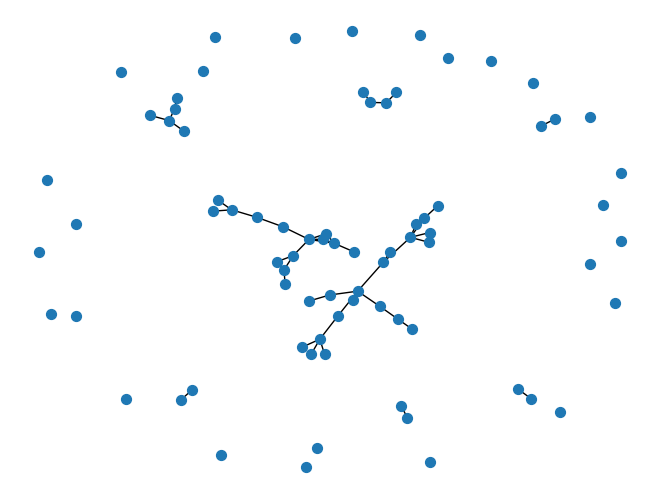

In [ ]:
# Draw network of the nodes with at least a degree centrality score of 100

net.draw(core100, with_labels=False, node_size=50)

In [ ]:
# largest connected component(LCC)

# Make sure core100 is connected before computing diameter
if not net.is_connected(core100):
    # Work with the largest connected component
    lcc = max(net.connected_components(core100), key=len)
    g_core_lcc = core100.subgraph(lcc).copy()
    print(f"Core100 is NOT fully connected. Using its largest connected component with {len(g_core_lcc.nodes())} nodes.")
else:
    g_core_lcc = core100
    print("Core100 is connected.")

# Compute Diameter :Longest shortest path in the largest connected part of core100.
diameter = net.diameter(g_core_lcc)
print(f"Diameter: {diameter}")

# Compute Average Clustering Coefficient : How tightly nodes form triangles.
avg_clustering = net.average_clustering(core100)
print(f"Average Clustering Coefficient: {avg_clustering:.4f}")

# Compute  Degree Centrality (normalized degree): Nodes with most connections (normalized)
deg_centrality = net.degree_centrality(core100)
top_nodes = sorted(deg_centrality.items(), key=lambda x: -x[1])[:5]
print("Top 5 nodes by degree centrality:")
for node, score in top_nodes:
    print(f"Node {node}: {score:.3f}")


Core100 is NOT fully connected. Using its largest connected component with 20 nodes.
Diameter: 7
Average Clustering Coefficient: 0.0766
Top 5 nodes by degree centrality:
Node 33: 0.066
Node 481: 0.066
Node 4429: 0.066
Node 8: 0.053
Node 2501: 0.053


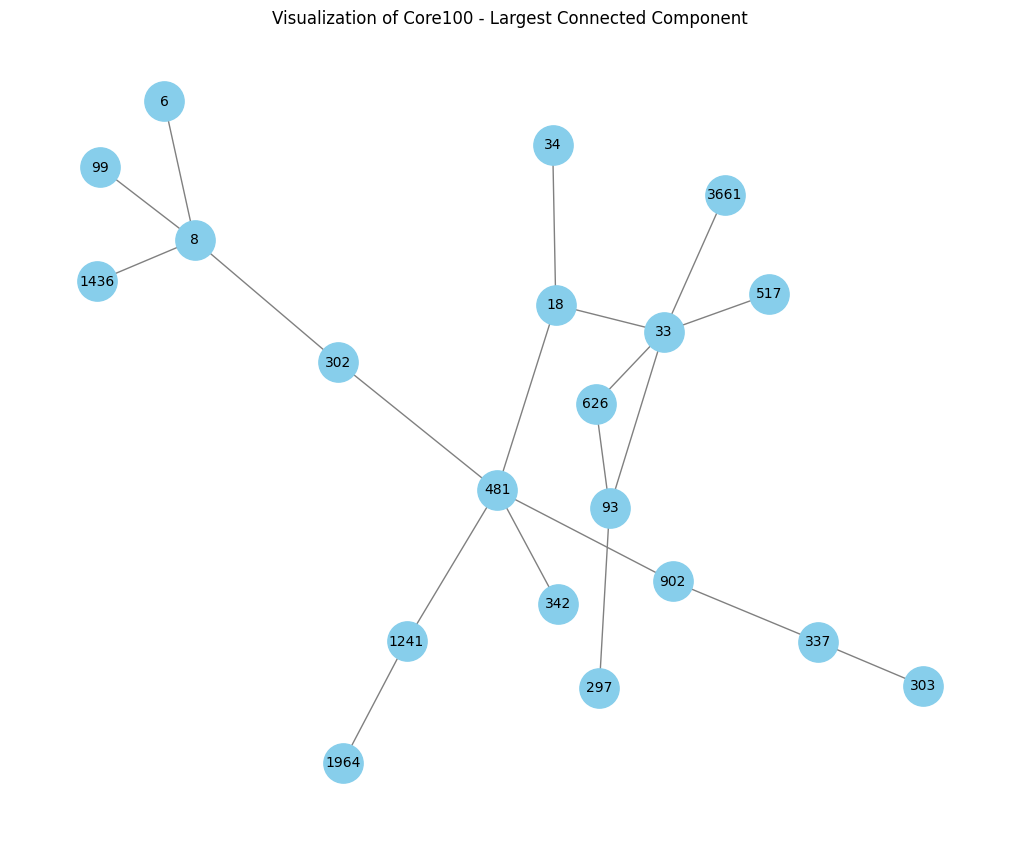

In [ ]:
# Set a layout
pos = net.spring_layout(g_core_lcc, seed=42)  # spring_layout = force-directed

plt.figure(figsize=(10, 8))
net.draw(
    g_core_lcc,
    pos,
    with_labels=True,
    node_color='skyblue',
    edge_color='gray',
    node_size=800,
    font_size=10
)
plt.title("Visualization of Core100 - Largest Connected Component")
plt.show()

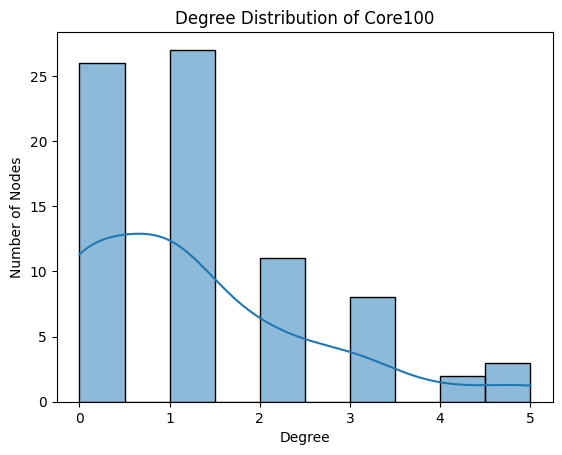

In [ ]:
# Degree Distribution
# Get degrees
degrees = [deg for _, deg in core100.degree()]

# Plot degree distribution
sns.histplot(degrees, bins=10, kde=True)
plt.title("Degree Distribution of Core100")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.show()

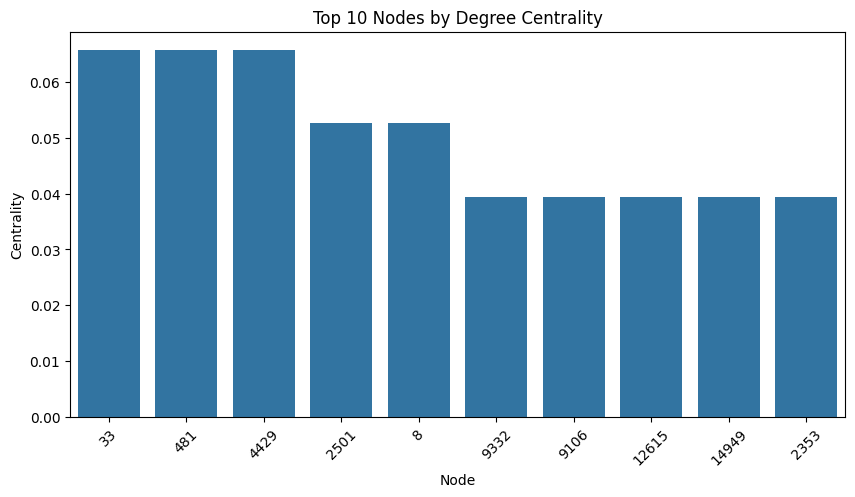

In [ ]:
# Degree Centraility
# Degree centrality as DataFrame
deg_df = pd.DataFrame(list(net.degree_centrality(core100).items()), columns=["Node", "Centrality"])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Node", y="Centrality", data=deg_df.sort_values("Centrality", ascending=False).head(10))
plt.title("Top 10 Nodes by Degree Centrality")
plt.xticks(rotation=45)
plt.show()


**Summary**

*   The amazon dataset has 262,111 nodes which could  represent products or entities like users or pages.
*   It has 899,792 Edges which are possibly co-purchases, links, or recommendations.
*   A Minimum Degree of 1 indicates there are nodes connected to only one other node — maybe niche or isolated items.
*   A Maximum Degree of 420 suggests that it's a hub node and possibly a very popular item frequently bought with others.
*   Node '14949' is the most connected product, with 420 edges. It likely represents a very popular product that co-occurs with many others in customer purchases.
*   Only 20 of the 77 nodes form the largest connected component (LCC).
*   The diameter which is the Longest shortest path between any two nodes in the LCC is 7 hops.For a 20-node network, this is relatively sparse, suggesting the need for longer paths between important nodes
*   Average Clustering Coefficient: 0.0766 suggests a hub-and-spoke or tree-like structure rather than a tightly-knit community.
*   Degree Distribution and Degree Centrality (normalized) is visualized.
*   The graph is visualized  by LCC .Since core100 has 77 nodes, and the LCC has 20 nodes, we recommend visualizing the LCC for clarity.















## Understanding product groups

In order to understand centrality measures between different groups within the nodes, categorical information is needed. The data source also offered a file with metadata describing several attriutes of the products within the data set. The text file was parsed and a data frame was created to apply categoircal information to the nodes and/or edges. The key below describes the meta data information.


### Key

The metadata was in text format. Manually scanning the text file almost all products had the following information.

- Id: Product ID number

- ASIN: Amazon Standard Identification Number

- title: Product name

- group: Product category

- salesrank: Total sales ranking among the products in the data set

- similar: ASIN Number of similar products found in the data set

- categories: Number of unique categories
    - Sub category names exist (example below) but **only the number of unique categories was extracted**
    - (|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368])
    

- reviews: Numbers of total, downloaded, and average review rating (total: 2  downloaded: 2  avg rating: 5)
    - **Only the above was extracted** but detailed information on the individual reviews existed that included
        - Date
        - customer ID
        - rating
        - votes
        - number that found the review helpful

In [ ]:
from io import StringIO

# Read in metadata csv file
url = 'https://www.dropbox.com/scl/fi/pg3zu565iu0la9z8nk7cm/amazon_meta_v2.csv?rlkey=336jkd8yiet9r43oxt73mal1p&st=feuywf92&dl=1' # Replace with your URL
r = requests.get(url)

data = r.content.decode('utf-8')

meta_data = pd.read_csv(StringIO(data))

meta_data.head()

,ID,ASIN,TITLE,GROUP,SALESRANK,CATEGORIES,NUM_SIMILAR,SIMILAR_PRODUCT_ASIN,REVIEWS_TOTAL,REVIEWS_DOWNLOADED,REVIEWS_AVG_RATING
0,0,0771044445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0827229534,PATTERNS OF PREACHING: A SERMON SAMPLER,BOOK,396585.0,2.0,5.0,0804215715 156101074X 0687023955 0687074231...,2.0,2.0,5.0
2,2,0738700797,CANDLEMAS: FEAST OF FLAMES,BOOK,168596.0,2.0,5.0,0738700827 1567184960 1567182836 0738700525...,12.0,12.0,4.5
3,3,0486287785,WORLD WAR II ALLIED FIGHTER PLANES TRADING CARDS,BOOK,1270652.0,1.0,0.0,NaN,1.0,1.0,5.0
4,4,0842328327,LIFE APPLICATION BIBLE COMMENTARY: 1 AND 2 TIM...,BOOK,631289.0,5.0,5.0,0842328130 0830818138 0842330313 0842328610...,1.0,1.0,4.0


### Amazon Product EDA

A brief EDA was carried out on the information detailing each product.

In [ ]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548552 entries, 0 to 548551
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    548552 non-null  int64  
 1   ASIN                  548552 non-null  object 
 2   TITLE                 542684 non-null  object 
 3   GROUP                 542684 non-null  object 
 4   SALESRANK             542684 non-null  float64
 5   CATEGORIES            542684 non-null  float64
 6   NUM_SIMILAR           542684 non-null  float64
 7   SIMILAR_PRODUCT_ASIN  379093 non-null  object 
 8   REVIEWS_TOTAL         542684 non-null  float64
 9   REVIEWS_DOWNLOADED    542684 non-null  float64
 10  REVIEWS_AVG_RATING    542684 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 46.0+ MB


In [ ]:
# Inspect the unique values in the GROUP column
meta_data["GROUP"].value_counts()

,count
GROUP,
BOOK,393561
MUSIC,103144
VIDEO,26131
DVD,19828
TOY,8
SOFTWARE,5
CE,4
VIDEO GAMES,1
BABY PRODUCT,1


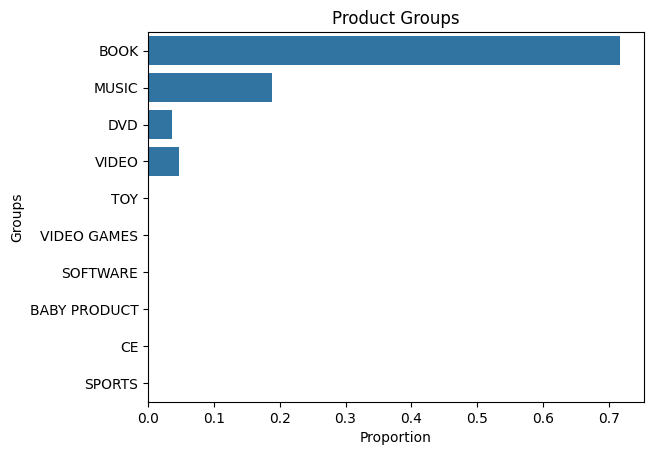

In [ ]:
# Visualize the proportion of products in earch group

sns.countplot(data = meta_data, y = "GROUP", stat = "proportion")
plt.title("Product Groups")
plt.ylabel("Groups")
plt.xlabel("Proportion")
plt.show()

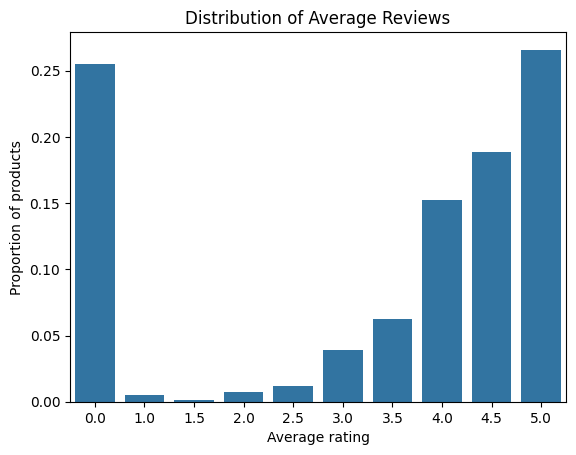

In [ ]:
# Look at the distribution of review scores

sns.countplot(data = meta_data, x = "REVIEWS_AVG_RATING", stat = "proportion")
plt.xlabel("Average rating")
plt.ylabel("Proportion of products")
plt.title("Distribution of Average Reviews")
plt.show()

### Label nodes

We can label use a category like GROUPS to label our nodes and as an example we will use the previous subgraph created using the largest connected component of the nodes with a degree centrality score of over 100.

In [ ]:
# Create category dictionary for each node

node_categories = {}
node_list = g_core_lcc.nodes()
# Convert ID data type to string
meta_data["ID"] = meta_data["ID"].astype(str)

# Handle missing values in group
meta_data["GROUP"] = meta_data["GROUP"].fillna("UNKNOWN")


# for i, r in meta_data[meta_data["ID"].isin(node_list)][["ID", "GROUP"]].iterrows():
#     node_categories[r[0]] = r[1]



for i, r in meta_data[meta_data["ID"].isin(node_list)][["ID", "GROUP"]].iterrows():
    node_categories[r["ID"]] = r["GROUP"]

category_colors = {'BOOK': "#ffa500",
                    'MUSIC': "#00b5e3",
                   'UNKNOWN': "#d3d3d3"  # light gray
                    }

# Assign node colors
node_colors = [category_colors.get(node_categories.get(node, "UNKNOWN"), "#d3d3d3") for node in node_list]

# node_colors = [catergory_colors[node_categories[node]] for node in node_list]

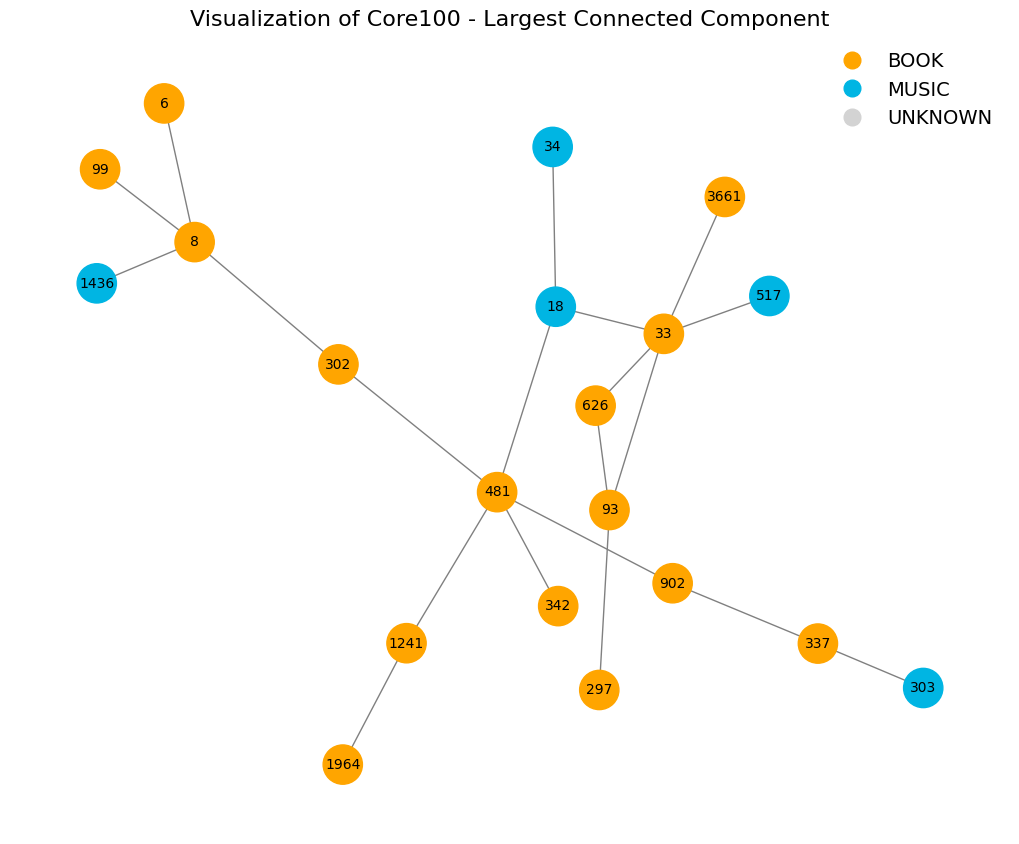

In [ ]:
# Replot the lcc subgraph

# Set a layout
pos = net.spring_layout(g_core_lcc, seed=42)  # spring_layout = force-directed

plt.figure(figsize=(10, 8))
net.draw(
    g_core_lcc,
    pos,
    with_labels=True,

    # UPDATE COLOR OF NODE BASED ON GROUP
    node_color=node_colors,
    edge_color='gray',
    node_size=800,
    font_size=10
)


# Manually create a legend using matplotlib

import matplotlib.lines as mlines

legend_elements = []
for key, value in category_colors.items():
    legend_elements.append(mlines.Line2D([], [], color=value, marker='o',
                                         linestyle='None', label=key))

# Create legend
plt.legend(handles=legend_elements,
           loc='upper right',
           markerscale = 2,
           fontsize  = 14,
           frameon = False)

plt.title("Visualization of Core100 - Largest Connected Component",fontsize=16)
plt.show()

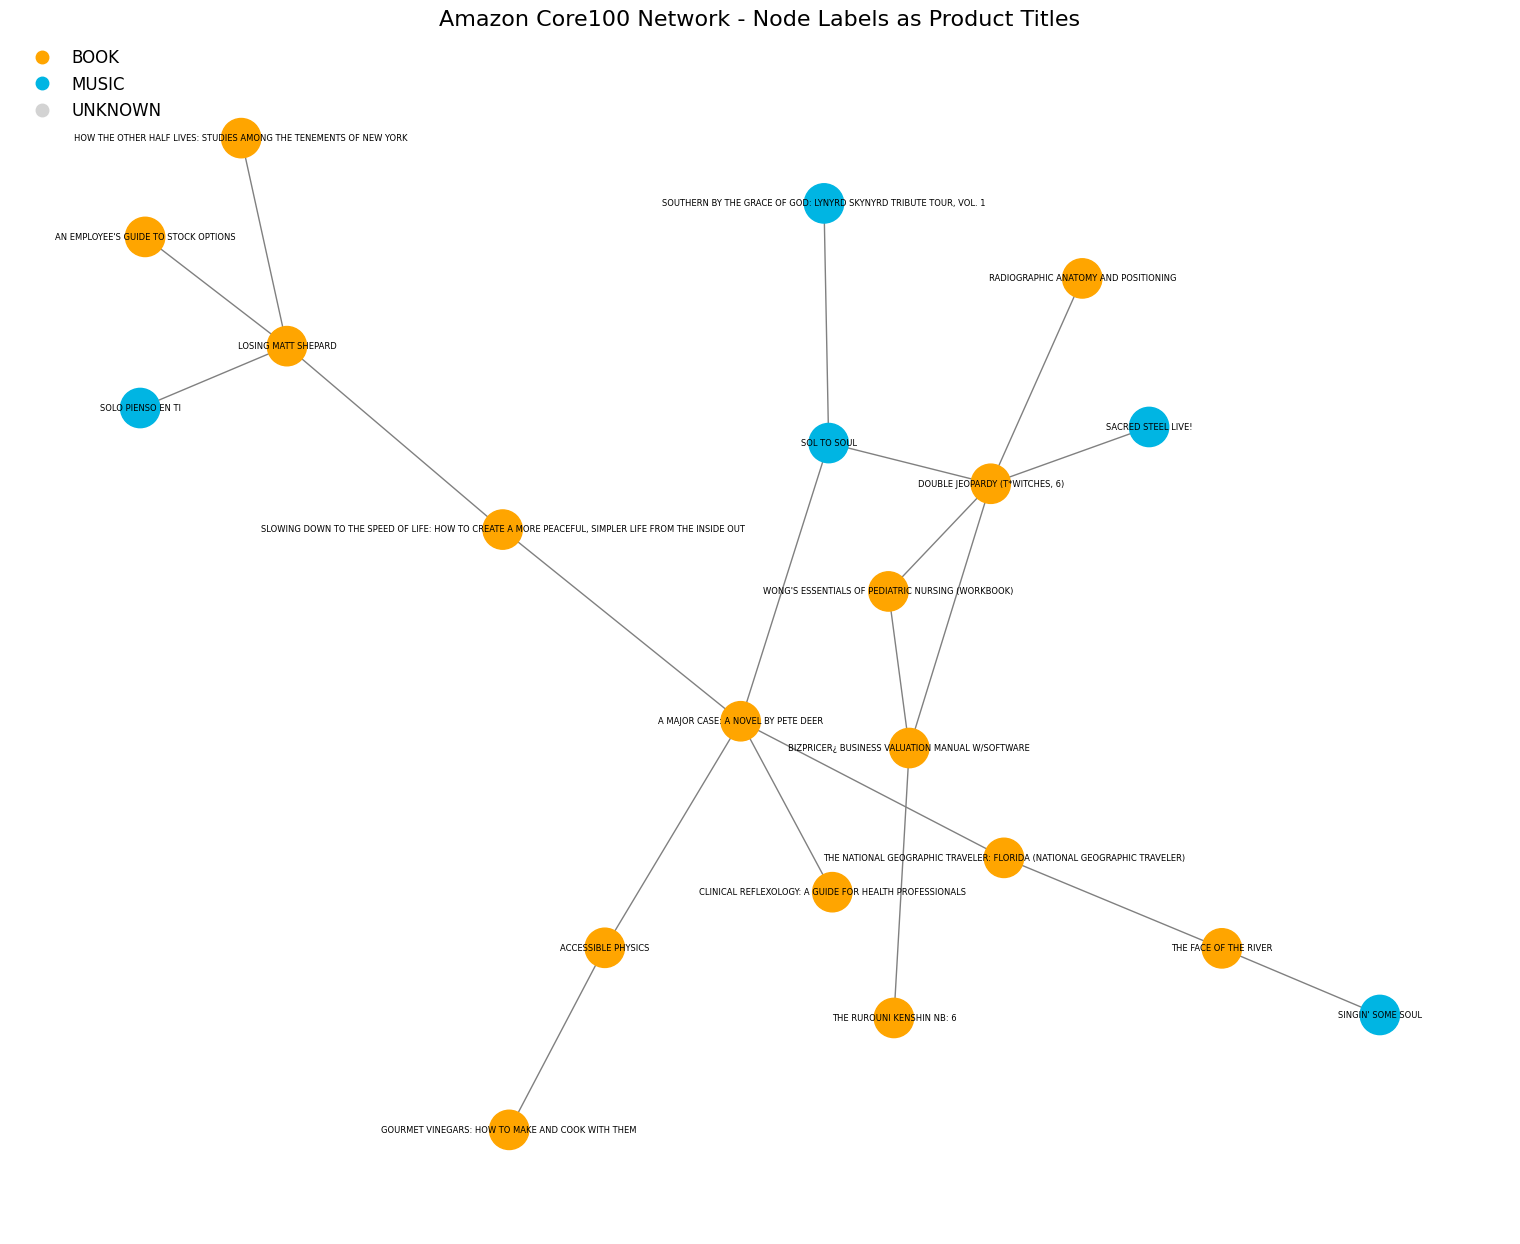

In [ ]:
# Create a dictionary of titles (fallback to ID if title is missing)
node_labels = {}
for node in g_core_lcc.nodes():
    row = meta_data[meta_data["ID"] == node]
    if not row.empty and pd.notna(row["TITLE"].values[0]):
        node_labels[node] = row["TITLE"].values[0]
    else:
        node_labels[node] = node  # fallback to ID


# Plot the network graph by product Title
plt.figure(figsize=(15, 12))

# Draw the nodes and edges only
net.draw(
    g_core_lcc,
    pos,
    with_labels=False,  # disable default labels
    node_color=node_colors,
    edge_color='gray',
    node_size=800,
)

# Now draw the custom labels (product titles)
net.draw_networkx_labels(g_core_lcc, pos, labels=node_labels, font_size=6)

# Title and legend
plt.title("Amazon Core100 Network - Node Labels as Product Titles", fontsize=16)
plt.legend(handles=legend_elements, loc='upper left', markerscale=1.5, fontsize=12, frameon=False)
plt.axis('off')
plt.show()


In [ ]:
# Set the centrality metric as an attribute for each node
degree_centrality = net.degree_centrality(g_core_lcc)
eigenvector_centrality = net.eigenvector_centrality(g_core_lcc)


net.set_node_attributes(g_core_lcc, degree_centrality, "degree_centrality")
net.set_node_attributes(g_core_lcc, eigenvector_centrality, "eigenvector_centrality")
net.set_node_attributes(g_core_lcc, node_categories, "category")

In [ ]:
# Convert attributes dictionary to data frame
attributes_dict = dict(g_core_lcc.nodes(data=True))
attributes_df = pd.DataFrame(attributes_dict)
attributes_df.head()

,3661,33,297,99,337,34,303,8,1436,481,902,626,18,93,1241,517,1964,6,302,342
degree_centrality,0.052632,0.263158,0.052632,0.052632,0.105263,0.052632,0.052632,0.210526,0.052632,0.263158,0.105263,0.105263,0.157895,0.157895,0.105263,0.052632,0.052632,0.052632,0.105263,0.052632
eigenvector_centrality,0.19239,0.52624,0.131095,0.03745,0.065058,0.136208,0.023785,0.102433,0.03745,0.356614,0.154163,0.323485,0.372565,0.358581,0.150493,0.19239,0.05502,0.03745,0.167827,0.130377
category,BOOK,BOOK,BOOK,BOOK,BOOK,MUSIC,MUSIC,BOOK,MUSIC,BOOK,BOOK,BOOK,MUSIC,BOOK,BOOK,MUSIC,BOOK,BOOK,BOOK,BOOK


In [ ]:
# Get the average degree centrality for each metric grouped by category

# Transpose the data frame
attributes_df_transposed = attributes_df.T
degree_centrality_mean_grouped = attributes_df_transposed.groupby("category")["degree_centrality"].mean()
degree_centrality_mean_grouped.head()

,degree_centrality
category,
BOOK,0.115789
MUSIC,0.073684


In [ ]:
# Repeat for eigenvector centrality
eigenvector_centrality_mean_grouped = attributes_df_transposed.groupby("category")["eigenvector_centrality"].mean()
eigenvector_centrality_mean_grouped.head()

,eigenvector_centrality
category,
BOOK,0.185912
MUSIC,0.15248


In [ ]:
# Top degree centrality nodes for books

# Merge to add titles based on index (node ID)
attributes_with_titles = attributes_df_transposed.merge(
    meta_data[["ID", "TITLE"]],
    how="left",
    left_index=True,
    right_on="ID"
)

attributes_with_titles = attributes_with_titles.drop(columns=["ID"])

#attributes_df_transposed[attributes_df_transposed['category'] == "BOOK"].sort_values(by=['degree_centrality']).head()
attributes_with_titles[attributes_with_titles['category'] == "BOOK"].sort_values(by='degree_centrality').head()

,degree_centrality,eigenvector_centrality,category,TITLE
3661,0.052632,0.19239,BOOK,RADIOGRAPHIC ANATOMY AND POSITIONING
297,0.052632,0.131095,BOOK,THE RUROUNI KENSHIN NB: 6
99,0.052632,0.03745,BOOK,AN EMPLOYEE'S GUIDE TO STOCK OPTIONS
1964,0.052632,0.05502,BOOK,GOURMET VINEGARS: HOW TO MAKE AND COOK WITH THEM
6,0.052632,0.03745,BOOK,HOW THE OTHER HALF LIVES: STUDIES AMONG THE TE...


In [ ]:
# Top degree centrality nodes for music
attributes_with_titles[attributes_with_titles['category'] == "MUSIC"].sort_values(by='degree_centrality').head()

,degree_centrality,eigenvector_centrality,category,TITLE
34,0.052632,0.136208,MUSIC,SOUTHERN BY THE GRACE OF GOD: LYNYRD SKYNYRD T...
303,0.052632,0.023785,MUSIC,SINGIN' SOME SOUL
1436,0.052632,0.03745,MUSIC,SOLO PIENSO EN TI
517,0.052632,0.19239,MUSIC,SACRED STEEL LIVE!
18,0.157895,0.372565,MUSIC,SOL TO SOUL


In [ ]:
# Top eigenvector centrality nodes for books
#attributes_df_transposed[attributes_df_transposed['category'] == "BOOK"].sort_values(by=['eigenvector_centrality']).head()

attributes_with_titles[attributes_with_titles['category'] == "BOOK"].sort_values(by='eigenvector_centrality').head()

,degree_centrality,eigenvector_centrality,category,TITLE
99,0.052632,0.03745,BOOK,AN EMPLOYEE'S GUIDE TO STOCK OPTIONS
6,0.052632,0.03745,BOOK,HOW THE OTHER HALF LIVES: STUDIES AMONG THE TE...
1964,0.052632,0.05502,BOOK,GOURMET VINEGARS: HOW TO MAKE AND COOK WITH THEM
337,0.105263,0.065058,BOOK,THE FACE OF THE RIVER
8,0.210526,0.102433,BOOK,LOSING MATT SHEPARD


In [ ]:
# Top eigenvector centrality nodes for music
#attributes_df_transposed[attributes_df_transposed['category'] == "MUSIC"].sort_values(by=['eigenvector_centrality']).head()


attributes_with_titles[attributes_with_titles['category'] == "MUSIC"].sort_values(by='eigenvector_centrality').head()


,degree_centrality,eigenvector_centrality,category,TITLE
303,0.052632,0.023785,MUSIC,SINGIN' SOME SOUL
1436,0.052632,0.03745,MUSIC,SOLO PIENSO EN TI
34,0.052632,0.136208,MUSIC,SOUTHERN BY THE GRACE OF GOD: LYNYRD SKYNYRD T...
517,0.052632,0.19239,MUSIC,SACRED STEEL LIVE!
18,0.157895,0.372565,MUSIC,SOL TO SOUL


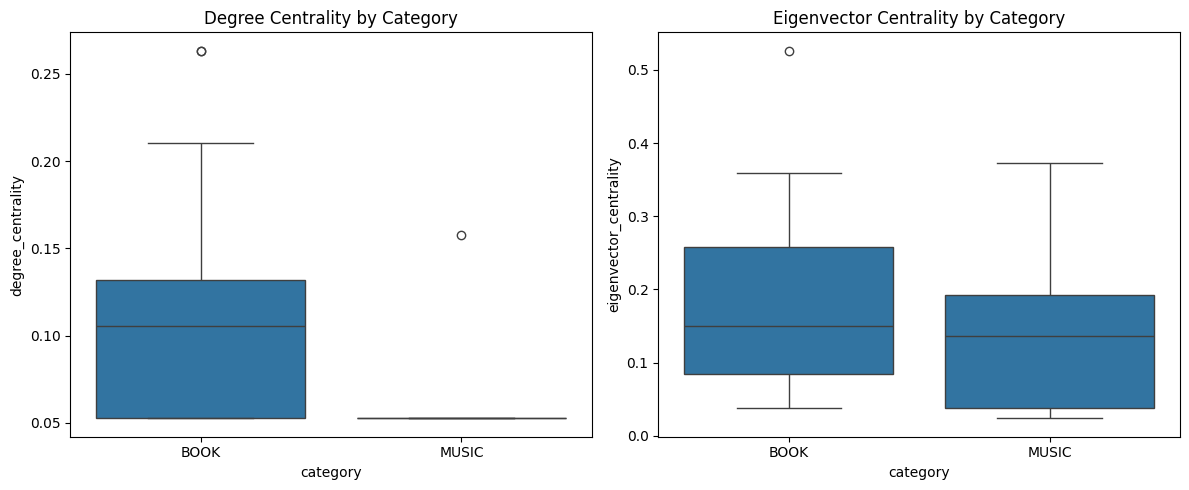

In [ ]:
# Boxplot for visual comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=attributes_df_transposed, x="category", y="degree_centrality")
plt.title("Degree Centrality by Category")

plt.subplot(1, 2, 2)
sns.boxplot(data=attributes_df_transposed, x="category", y="eigenvector_centrality")
plt.title("Eigenvector Centrality by Category")

plt.tight_layout()
plt.show()

**Summary**

BOOK products tend to have more direct connections (i.e., are co-purchased or linked with more other products) than MUSIC ones.

BOOK products have higher eigenvector scores and hence BOOK nodes may be more central in the network, which could reflect how books are recommended or purchased together more frequently in Amazon's structure.

MUSIC products are less connected and slightly less influential, possibly due to niche markets or fewer co-purchase relationships.

Hence both centrality measures suggest that BOOK products occupy more prominent positions in the co-purchase network compared to MUSIC. This may reflect consumer behavior or recommendation engine design on platforms like Amazon, where books tend to form larger interconnected communities.

Interesting details:
Node 3661 which is the book(THE RUROUNI KENSHIN NB: 6) has a much higher eigenvector centrality (0.1924), meaning it's connected to more influential nodes, even if it doesn't have more connections itself.This is example of how degree ≠ influence in network analysis.

